# Importing Libraries

In [16]:
# import libraries
import numpy as np
import pandas as pd
from IPython.display import display
from IPython.core.display import HTML
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load Datasets

In [20]:
df_books = pd.read_csv("cleaned_books.csv")

# Helper Function

In [ ]:
# Function to display images in a DataFrame
def display_images(df, image_column):
    # Create an HTML representation of the DataFrame with images
    html = df.to_html(escape=False, formatters={
        image_column: lambda url: f'<img src="{url}" width="50">'
    })
    display(HTML(html))

# Content-Based

## Function to Create TF-IDF Matrix

In [ ]:
# Creates TF-IDF matrix from book titles and authors.
def create_tfidf_matrix():
    # Combine title and authors, handle potential NaNs
    authors_title_df = df_books[['book_id', 'original_title', 'title', 'authors', 'average_rating', 'image_url']].copy()
    authors_title_df['content'] = authors_title_df['original_title'].fillna('') + ' ' + authors_title_df['authors'].fillna('')
    
    # Initializes a `TfidfVectorizer` with English stop words.
    tfidf = TfidfVectorizer(stop_words='english')
    
    # Fits and transforms the 'content' column to create a TF-IDF matrix, 
    # where rows represent books and columns represent TF-IDF scores for terms.
    tfidf_matrix = tfidf.fit_transform(authors_title_df['content'])
    return tfidf_matrix, authors_title_df 

## Get Content-Based Recommendations for a Sample Book

In [22]:
def rcmd_content_based(ori_book_id, k=5):
    # Get the index of the book that matches the ID
    idx_series = df_books.index[df_books['book_id'] == ori_book_id]
    idx = idx_series[0]
    
    tfidf_matrix, authors_title_df = create_tfidf_matrix()
    
    v = cosine_similarity(tfidf_matrix, tfidf_matrix)
    # Get the pairwise similarity scores of all books with that book
    sim_scores = list(enumerate(v[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the k most similar books (excluding the book itself)
    sim_scores = sim_scores[1:k+1]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    # Get the similarity scores
    similarity_values = [i[1] for i in sim_scores]

    # Return the top k most similar books
    rcmd = authors_title_df.iloc[book_indices][["book_id", "title", "authors", "average_rating", "image_url"]].copy()
    rcmd['similarity_score'] = similarity_values
    rcmd = rcmd.reset_index(drop=True)

    return rcmd

In [23]:
book_id = 827
title = df_books.loc[df_books['book_id'] == book_id, 'original_title'].iloc[0]
print("Book Title: ", title)
rcmd_c_b = rcmd_content_based(book_id)

Book Title:  To All the Boys I've Loved Before


In [ ]:
# Display the DataFrame with images
display_images(rcmd_c_b, 'image_url')

,book_id,title,authors,average_rating,image_url,similarity_score
0,2112,"P.S. I Still Love You (To All the Boys I've Loved Before, #2)",Jenny Han,4.17,,0.543720
1,1284,"It's Not Summer Without You (Summer, #2)",Jenny Han,4.14,,0.520045
2,1614,"We'll Always Have Summer (Summer, #3)",Jenny Han,4.17,,0.438682
3,1066,"The Summer I Turned Pretty (Summer, #1)",Jenny Han,3.96,,0.379573
4,9769,The Summer I Turned Pretty Trilogy: The Summer I Turned Pretty; It's Not Summer Without You; We'll Always Have Summer,Jenny Han,4.46,,0.379573


# Evaluation

## Load Book Tags Dataset

In [25]:
df_tags = pd.read_csv("cleaned_book_tags.csv")

## Prepare Data for Evaluation

In [26]:
df_merged = df_books.merge(df_tags, on='book_id', how='inner')
df_merged['tag_set'] = df_merged['combined_tags'].apply(lambda x: set(x.split()))
tfidf_matrix, authors_title_df = create_tfidf_matrix()

## Function to Define Ground Truth for Evaluation


In [ ]:
def get_ground_truth(df_merged, min_shared_tags=2):
    # Creates a dictionary `tag_sets` mapping each `book_id` to its set of tags.
    tag_sets = dict(zip(df_merged['book_id'], df_merged['tag_set']))
    ground_truth = {}
    
    # For each book, identifies other books as "ground truth" relevant items 
    # if they share at least `min_shared_tags`.
    for bid, tags in tag_sets.items():
        ground_truth[bid] = [
            other_id for other_id, other_tags in tag_sets.items()
            if other_id != bid and len(tags & other_tags) >= min_shared_tags
        ]
    return ground_truth

## Calculate Similarity Matrix and Ground Truth

In [28]:
v = cosine_similarity(tfidf_matrix, tfidf_matrix)
ground_truth = get_ground_truth(df_merged)

## Function to Calculate Evaluation Metrics @K


In [ ]:
book_ids = authors_title_df['book_id'].tolist()
id_to_index = {bid: idx for idx, bid in enumerate(book_ids)}

def evaluation(query_id, k):
    idx = id_to_index[query_id]
    sims = v[idx].copy()
    sims[idx] = -1  # exclude self
    top_k_indices = sims.argsort()[-k:][::-1]
    top_k_ids = [book_ids[i] for i in top_k_indices]
    relevant = set(ground_truth.get(query_id, []))
    
    if not relevant:
        return 0.0, 0.0, 0.0, 0.0, 0.0
    
    # Precision: Proportion of the top `k` recommended items that are relevant.
    true_positives = len(set(top_k_ids) & relevant)
    pre = true_positives / k
    
    # Recall: Proportion of all relevant items for the user that are in the top `k` recommendations.
    recall = true_positives / len(relevant)
    
    # F1@K: The harmonic mean of Precision@k and Recall@k.
    if pre + recall == 0:
        f1 = 0.0
    else:
        f1 = (2 * pre * recall) / (pre + recall)
    
    # MAP@K: Sum of precision values at each rank where a relevant item is found 
    # in the top k, divided by min(number of relevant items, k).
    hits = 0
    sum_precisions = 0.0
    for i, book_id in enumerate(top_k_ids):
        if book_id in relevant:
            hits += 1
            sum_precisions += hits / (i + 1)
    map = sum_precisions / min(len(relevant), k)
    
    # MRR@K: The reciprocal of the rank of the first relevant item in the top k.
    mrr = 0.0
    for i, book_id in enumerate(top_k_ids):
        if book_id in relevant:
            mrr = 1 / (i + 1)
    
    return pre, recall, f1, map, mrr

## Evaluate Model for K=5 and Print Average Metrics

In [30]:
eval = [evaluation(bid, k=5) for bid in book_ids if bid in ground_truth and ground_truth[bid]]
precisions, recall, f1, maps, mrrs = zip(*eval)

print(f"Precision@5: {np.mean(precisions):.4f}")
print(f"Recall@5: {np.mean(recall):.4f}")
print(f"F1@5: {np.mean(f1):.4f}")
print(f"MAP@5: {np.mean(maps):.4f}")
print(f"MRR@5: {np.mean(mrrs):.4f}")

Precision@5: 0.9099
Recall@5: 0.0007
F1@5: 0.0014
MAP@5: 0.8887
MRR@5: 0.2141


## Evaluate Model with Various Ranking Metrics for K=1 to 5


In [31]:
results = []

for k in range(1, 6):  
    eval = [evaluation(bid, k) for bid in book_ids if bid in ground_truth and ground_truth[bid]]
    precision, recall, f1, map_score, mrr = zip(*eval)
    results.append({
        'num_recommendations': k,
        'precision@k': np.mean(precision),
        'recall@k': np.mean(recall),
        'f1-score@k': np.mean(f1),
        'mAP@k': np.mean(map_score),
        'MRR@k': np.mean(mrr)
    })

df_evaluation = pd.DataFrame(results)
df_evaluation

,num_recommendations,precision@k,recall@k,f1-score@k,mAP@k,MRR@k
0,1,0.942514,0.000153,0.000307,0.942514,0.942514
1,2,0.929508,0.000294,0.000588,0.922131,0.513770
2,3,0.920401,0.000430,0.000857,0.907505,0.351876
3,4,0.914399,0.000565,0.001126,0.896749,0.266393
4,5,0.909923,0.000696,0.001387,0.888748,0.214097


## Convert Precision and Recall to Percentage

In [32]:
df_evaluation['precision@k'] = df_evaluation['precision@k'] * 100
df_evaluation['recall@k'] = df_evaluation['recall@k'] * 100

## Plot Precision@k and Recall@k vs. Number of Recommendations

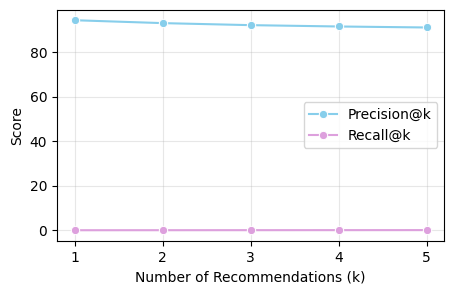

In [33]:
plt.figure(figsize=(5, 3))
sns.lineplot(
    data=df_evaluation,
    x='num_recommendations',
    y='precision@k',
    marker='o',
    label='Precision@k',
    color='skyblue'
)
sns.lineplot(
    data=df_evaluation,
    x='num_recommendations',
    y='recall@k',
    marker='o',
    label='Recall@k',
    color='plum'
)

plt.xlabel('Number of Recommendations (k)')
plt.ylabel('Score')
range_k = [1, 2, 3, 4, 5]
plt.xticks(np.arange(min(range_k), max(range_k)+1, 1.0))
plt.legend()
plt.grid(alpha=0.3)
plt.show()